In [2]:
"imports"

import csv 
import numpy as np 
import pandas as pd 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import KFold,train_test_split, LeaveOneOut, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt 


"load data set"

dataset = pd.read_csv("C:/Users/nibha/Desktop/syria.csv") 
X = dataset.drop('status', axis=1) # seperate features 
y = dataset['status'] #seperate label

"convert categorical classes"

deathdate=dataset['deathdate'] 

age=dataset['age'] 
age=age.astype('category')
age=age.cat.codes
gender=dataset['gender'] 
gender=gender.astype('category')
gender=gender.cat.codes
province=dataset['province'] 
province=province.astype('category')
province=province.cat.codes
deathcause=dataset['deathcause']
deathcause=deathcause.astype('category')
deathcause=deathcause.cat.codes

X_features = pd.concat([age,gender,province,deathcause,deathdate], axis=1) #combine categorical and non categorial features 

# print(X_features.head(9))

X_features=np.asarray(X_features)



y = y.astype('category') 

y_target = y.cat.codes 
# print(y_target.head(10)) 
y_target=np.asarray(y_target) #class0-civilian


'method for contingeny and other values'

def con(t_value,samples,target_pred_prob,y_true):
    target_pred=[]
    for j in range(samples):
      
        threshold=target_pred_prob[j]
        if (threshold<= t_value):
            target_pred.insert(j,1)
        else:
            target_pred.insert(j,0)
        
    tn, fp, fn, tp = confusion_matrix(y_true,target_pred).ravel() 
    
    sens= tp/(tp+fn) #True positive rate
    spec=tn/(fp+tn)
    fpr=100-(spec) #100-specificity
    acc=(tp+tn)/(tp+tn+fp+fn) 
    F1= (2*sens*spec)/(sens+spec) 
    
    return([tn,fp,fn,tp,sens,spec,fpr,acc,F1,target_pred])

[99.0, 99.002389169100084, 99.045659676134861, 99.192991770639765, 100.0]
[0.0, 0.0016260162601626016, 0.34715447154471546, 0.79756097560975614, 1.0]
0.163206687947


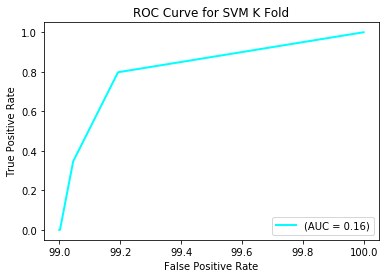

In [5]:
"k fold"

"get epoch like curve"

kf = KFold(n_splits=5) 

# def k_model_epoch(c,g):
#     svm=SVC(kernel='rbf', C=c, gamma=g)
    
#     for train_index, test_index in kf.split(X_features):
    
#         svm.fit(X_features[train_index], y_target[train_index])
#         kftarget_pred_real = svm.predict(X_features[test_index])
   
#     scores=cross_val_score(svm, X_features, y_target)
#     avg_score=scores.mean()
    
#     return (avg_score)

# for i in range(1,12):
   
#     k_model3= np.asarray([k_model_epoch(100000.0,0.000001)])
#     k_model4= np.asarray([k_model_epoch(10000.0,0.00001)])
#     k_model5= np.asarray([k_model_epoch(1000.0,0.0001)])
#     k_model6= np.asarray([k_model_epoch(100.0,0.001)])
#     k_model7= np.asarray([k_model_epoch(10.0,0.1)])
#     k_model8= np.asarray([k_model_epoch(1.0,1.0)])    
#     k_model9= np.asarray([k_model_epoch(0.1,10.0)])
#     k_model10= np.asarray([k_model_epoch(0.01,100.0)])
#     k_model11= np.asarray([k_model_epoch(0.001,10000.0)])

    
# k_avg_score=([k_model3,k_model4,k_model5,k_model6,k_model7,k_model8,k_model9,k_model10
#             ,k_model11])

# x=[0,1,2,3,4,5,6,7,8]
# fig=plt.figure()
# ax = fig.add_subplot(111) 
# ax.plot(k_avg_score,marker="o",c='green', linewidth=2, label='accuracy')
# ax.set(title='SVM Accuracy for K-Fold', ylabel='Accuracy',xlabel='gamma and c')
# ax.legend(loc='best') 
# labels=['g=0.000001/c=100000.0','g=0.00001/c=10000.0','g=0.0001/c=1000.0','g=0.001/c=100.0','g=0.1/c=10.0',
#        'g=1.0/c=1.0','g=10.0/c=0.1','g=100.0/c=0.01','g=10000.0/c=0.001']
# plt.xticks(x,labels, rotation='80')
# plt.grid()
# plt.show()

"create svm"

svm1=SVC(kernel='rbf', C=1000.0, gamma=0.0001, probability=True)
    
for train_index, test_index in kf.split(X_features):
    svm1.fit(X_features[train_index], y_target[train_index])
    kftarget_pred_real = svm1.predict(X_features[test_index])
    
kftarget_pred_prob = svm1.predict_proba(X_features)[:,0]

samples=len(X_features)
kf_thresh0=con(0,samples,kftarget_pred_prob,y_target)
kf_thresh1=con(0.25,samples,kftarget_pred_prob,y_target)
kf_thresh2=con(0.5,samples,kftarget_pred_prob,y_target)
kf_thresh3=con(0.75,samples,kftarget_pred_prob,y_target)
kf_thresh4=con(1,samples,kftarget_pred_prob,y_target)


"roc curve"

x_k_fpr=[kf_thresh0[6],kf_thresh1[6],kf_thresh2[6],kf_thresh3[6],kf_thresh4[6]] #fpr or 100-specificty
print(x_k_fpr)
y_k_tpr=[kf_thresh0[4],kf_thresh1[4],kf_thresh2[4],kf_thresh3[4],kf_thresh4[4]] #sensitivity
print(y_k_tpr)
k_auc=roc_auc_score(y_target,kftarget_pred_prob)
print(k_auc)

plt.title('ROC Curve for SVM K Fold')
plt.plot(x_k_fpr,y_k_tpr, color='aqua',lw=2, label='(AUC = %0.2f)' % k_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# print(kf_thresh0[0],kf_thresh0[1],kf_thresh0[2],kf_thresh0[3],kf_thresh0[4],
#       kf_thresh0[5],kf_thresh0[6],kf_thresh0[7])

# print(kf_thresh1[0],kf_thresh1[1],kf_thresh1[2],kf_thresh1[3],kf_thresh1[4]
#       ,kf_thresh1[5],kf_thresh1[6],kf_thresh1[7])

# print(kf_thresh2[0],kf_thresh2[1],kf_thresh2[2],kf_thresh2[3],kf_thresh2[4]
#        ,kf_thresh2[5],kf_thresh2[6],kf_thresh2[7])

# print(kf_thresh3[0],kf_thresh3[1],kf_thresh3[2],kf_thresh3[3],kf_thresh3[4]
#        ,kf_thresh3[5],kf_thresh3[6],kf_thresh3[7])

# print(kf_thresh4[0],kf_thresh4[1],kf_thresh4[2],kf_thresh4[3],kf_thresh4[4]
#        ,kf_thresh4[5],kf_thresh4[6],kf_thresh4[7])
#outout 3767 0 1230 0 0.0 1.0 0.753852311387 0.0
# 3758 9 1228 2 0.00162601626016 0.9976108309 0.752451470883 0.00324674062404
# 3081 686 303 927 0.753658536585 0.817892221927 0.802081248749 0.784462673857
# 3040 727 249 981 0.79756097561 0.80700822936 0.804682809686 0.802256791094
# 0 3767 0 1230 1.0 0.0 0.246147688613 0.0


In [ ]:

def l_model_epoch(c,g):
    
       
    svm=SVC(kernel='rbf', C=c, gamma=g)
    
    for train_index, test_index in loo.split(X_split):
    
        svm.fit(X_split[train_index], y_split[train_index])
        lootarget_pred_real = svm.predict(X_split[test_index])
   
    scores=cross_val_score(svm, X_split, y_split)
    avg_score=scores.mean()
    
    return (avg_score)


l_model3
l_model4
l_model5
l_model6
l_model7
l_model8
# for i in range(1,12):
   
#     l_model3= np.asarray([l_model_epoch(100000.0,0.000001)])
#     l_model4= np.asarray([l_model_epoch(10000.0,0.00001)])
#     l_model5= np.asarray([l_model_epoch(1000.0,0.0001)])
#     l_model6= np.asarray([l_model_epoch(100.0,0.001)])
#     l_model7= np.asarray([l_model_epoch(10.0,0.1)])
#     l_model8= np.asarray([l_model_epoch(1.0,1.0)])    
#     l_model9= np.asarray([l_model_epoch(0.1,10.0)])
#     l_model10= np.asarray([l_model_epoch(0.01,100.0)])
#     l_model11= np.asarray([l_model_epoch(0.001,10000.0)])

n= [3,4,5,6,7,8]

l_avg_score=([l_model3,l_model4,l_model5,l_model6,l_model7,l_model8])


fig=plt.figure()
ax = fig.add_subplot(111) 
ax.plot(n,l_avg_score,marker="o",c='blue', linewidth=2, label='accuracy')
ax.set(title='SVM score for LOO', ylabel='Cross Val score',xlabel='gamma and c')
ax.legend(loc='best') 
plt.grid()
plt.show()

"create svm"

svm2=SVC(kernel='rbf', C=1000.0, gamma=0.0001, probability=True)
    
for train_index, test_index in kf.split(X_split):
    svm2.fit(X_split[train_index], y_split[train_index])
    lootarget_pred_real = svm2.predict(X_split[test_index])
    
lootarget_pred_prob = svm2.predict_proba(X_split)[:,0]

samples=len(X_features)
loo_thresh0=con(0,samples,lootarget_pred_prob,y_split)
loo_thresh1=con(0.25,samples,lootarget_pred_prob,y_split)
loo_thresh2=con(0.5,samples,lootarget_pred_prob,y_split)
loo_thresh3=con(0.75,samples,lootarget_pred_prob,y_split)
loo_thresh4=con(1,samples,lootarget_pred_prob,y_split)

"ROC CURVE"

x_l_fpr=[loo_thresh0[6],loo_thresh1[6],loo_thresh2[6],loo_thresh3[6],loo_thresh4[6]] #fpr or 100-specificty
print(x_l_fpr)
y_l_tpr=[loo_thresh0[4],loo_thresh1[4],loo_thresh2[4],loo_thresh3[4],loo_thresh4[4]] #sensitivity
print(y_l_tpr)
l_auc=roc_auc_score(y_target,lootarget_pred_prob)
print(l_auc)

plt.title('ROC Curve for KNN LOO')
plt.plot(x_l_fpr,y_l_tpr, color='deeppink',lw=2, label='(AUC = %0.2f)' % l_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

[99.0, 99.003957783641155, 99.059366754617415, 99.188654353562001, 100.0]
[0.0, 0.0082644628099173556, 0.34297520661157027, 0.80165289256198347, 1.0]
0.16232636996


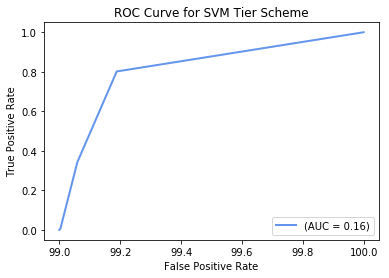

In [6]:
"3 tier"

"epochh like curve"

# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(X_features, y_target, test_size= 0.2,random_state=2)

#split train+validation set into train set and validation set 
X_train, X_valid, y_train, y_valid =train_test_split(X_trainval, y_trainval, test_size= 0.2,random_state=2)

# def t_model_epoch(c,g):
#     svm=SVC(kernel='rbf', C=c, gamma=g) 
#     svm.fit(X_train, y_train) # train on train+validation set
#     svm.fit(X_trainval, y_trainval) #train on training set
#     train_acc=svm.score(X_trainval, y_trainval)
#     test_acc=svm.score(X_test,y_test)       
#     return ([train_acc,test_acc])


# for i in range(1,12):
   
#     t_model3= np.asarray([t_model_epoch(100000.0,0.000001)])
#     t_model4= np.asarray([t_model_epoch(10000.0,0.00001)])
#     t_model5= np.asarray([t_model_epoch(1000.0,0.0001)])
#     t_model6= np.asarray([t_model_epoch(100.0,0.001)])
#     t_model7= np.asarray([t_model_epoch(10.0,0.1)])
#     t_model8= np.asarray([t_model_epoch(1.0,1.0)])    
#     t_model9= np.asarray([t_model_epoch(0.1,10.0)])
#     t_model10= np.asarray([t_model_epoch(0.01,100.0)])
#     t_model11= np.asarray([t_model_epoch(0.001,10000.0)])
  
    
# x=[0,1,2,3,4,5,6,7,8]

# y_train_acc=([t_model3[0,0],t_model4[0,0],t_model5[0,0],t_model6[0,0],t_model7[0,0],t_model8[0,0]
#              ,t_model9[0,0],t_model10[0,0],t_model11[0,0]])
# y_test_acc=([t_model3[0,1],t_model4[0,1],t_model5[0,1],t_model6[0,1],t_model7[0,1],t_model8[0,1]
#              ,t_model9[0,1],t_model10[0,1],t_model11[0,1]])

# fig=plt.figure()
# ax = fig.add_subplot(111) 
# ax.plot(x,y_train_acc,marker="o",c='green', linewidth=2, label='training accuracy')
# ax.plot(x,y_test_acc, marker="o",c='blue', linewidth=2,label='testing accuracy')
# ax.set(title='KNN Accuracy for Tier', ylabel='Accuracy',xlabel='Depth')
# labels=['g=0.000001/c=100000.0','g=0.00001/c=10000.0','g=0.0001/c=1000.0','g=0.001/c=100.0','g=0.1/c=10.0',
#        'g=1.0/c=1.0','g=10.0/c=0.1','g=100.0/c=0.01','g=10000.0/c=0.001']
# plt.xticks(x,labels, rotation='80')
# ax.legend(loc='best') 
# plt.grid()
# plt.show()

"create svm"

svm3=SVC(kernel='rbf', C=100.0, gamma=0.001, probability=True)

svm3.fit(X_train, y_train) # train on train+validation set
svm3.fit(X_trainval, y_trainval) #train on training set
    

tiertarget_pred_real=svm3.predict(X_test)
tiertarget_pred_prob = svm3.predict_proba(X_test)[:,0]

tsamples=len(X_test)
tier_thresh0=con(0,tsamples,tiertarget_pred_prob,y_test)
tier_thresh1=con(0.25,tsamples,tiertarget_pred_prob,y_test)
tier_thresh2=con(0.5,tsamples,tiertarget_pred_prob,y_test)
tier_thresh3=con(0.75,tsamples,tiertarget_pred_prob,y_test)
tier_thresh4=con(1,tsamples,tiertarget_pred_prob,y_test)

"ROC CURVE"

x_t_fpr=[tier_thresh0[6],tier_thresh1[6],tier_thresh2[6],tier_thresh3[6],tier_thresh4[6]] #fpr or 100-specificty
print(x_t_fpr)
y_t_tpr=[tier_thresh0[4],tier_thresh1[4],tier_thresh2[4],tier_thresh3[4],tier_thresh4[4]] #sensitivity
print(y_t_tpr)
t_auc=roc_auc_score(y_test,tiertarget_pred_prob)
print(t_auc)

plt.title('ROC Curve for SVM Tier Scheme')
plt.plot(x_t_fpr,y_t_tpr, color='cornflowerblue',lw=2, label='(AUC = %0.2f)' % t_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# print(tier_thresh0[0],tier_thresh0[1],tier_thresh0[2],tier_thresh0[3],tier_thresh0[4],
#       tier_thresh0[5],tier_thresh0[6],tier_thresh0[7])#tn,fp,fn,tp,sens,spec,acc,F1,
# print(tier_thresh1[0],tier_thresh1[1],tier_thresh1[2],tier_thresh1[3],tier_thresh1[4],
#       tier_thresh1[5],tier_thresh1[6],tier_thresh1[7])
# print(tier_thresh2[0],tier_thresh2[1],tier_thresh2[2],tier_thresh2[3],tier_thresh2[4]
#        ,tier_thresh2[5],tier_thresh2[6],tier_thresh2[7])
# print(tier_thresh3[0],tier_thresh3[1],tier_thresh3[2],tier_thresh3[3],tier_thresh3[4]
#        ,tier_thresh3[5],tier_thresh3[6],tier_thresh3[7])
# print(tier_thresh4[0],tier_thresh4[1],tier_thresh4[2],tier_thresh4[3],tier_thresh4[4]
#        ,tier_thresh4[5],tier_thresh4[6],tier_thresh4[7])
# output>758 0 242 0 0.0 1.0 0.758 0.0
# 754 4 240 2 0.00826446280992 0.994722955145 0.756 0.0163927298026
# 706 52 158 84 0.347107438017 0.931398416887 0.79 0.505739284679
# 615 143 48 194 0.801652892562 0.811345646438 0.809 0.806470146883
# 0 758 0 242 1.0 0.0 0.242 0.0
[99.0, 99.003957783641155, 99.059366754617415, 99.188654353562001, 100.0]
[0.0, 0.0082644628099173556, 0.34297520661157027, 0.80165289256198347, 1.0]
0.16232636996

0 2 83 194 242
758 755 712 615 0
0 3 46 143 758
242 240 159 48 0


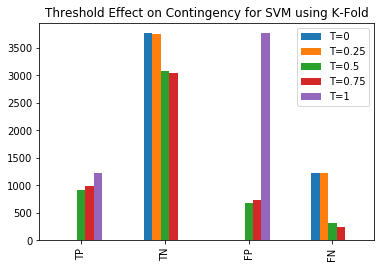

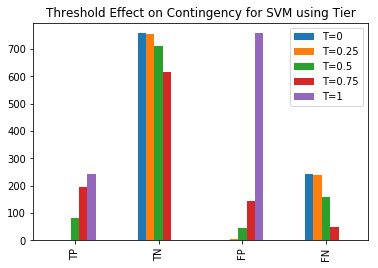

In [43]:
"bar graph for k fold"

groups1 ={'TP':[kf_thresh0[3],kf_thresh1[3],kf_thresh2[3],kf_thresh3[3],kf_thresh4[3]],
          'TN':[kf_thresh0[0],kf_thresh1[0],kf_thresh2[0],kf_thresh3[0],kf_thresh4[0]],
          'FP':[kf_thresh0[1],kf_thresh1[1],kf_thresh2[1],kf_thresh3[1],kf_thresh4[1]],
           'FN':[kf_thresh0[2],kf_thresh1[2],kf_thresh2[2],kf_thresh3[2],kf_thresh4[2]]}
                                           
# print(kf_thresh0[3],kf_thresh1[3],kf_thresh2[3],kf_thresh3[3],kf_thresh4[3])
# print(kf_thresh0[0],kf_thresh1[0],kf_thresh2[0],kf_thresh3[0],kf_thresh4[0])
# print(kf_thresh0[1],kf_thresh1[1],kf_thresh2[1],kf_thresh3[1],kf_thresh4[1])
# print(kf_thresh0[2],kf_thresh1[2],kf_thresh2[2],kf_thresh3[2],kf_thresh4[2])

# Convert data to pandas DataFrame.
df1=pd.DataFrame(groups1,columns= ['TP', 'TN', 'FP', 'FN']).T

ax1 = df1.plot(kind='bar', title='Threshold Effect on Contingency for SVM using K-Fold')
ax1.legend(['T=0','T=0.25','T=0.5','T=0.75','T=1']);

# "bar graph for loo"

# groups2 ={'TP':[loo_thresh0[3],loo_thresh1[3],loo_thresh2[3],loo_thresh3[3],loo_thresh4[3]],
#           'TN':[loo_thresh0[0],loo_thresh1[0],loo_thresh2[0],loo_thresh3[0],loo_thresh4[0]],
#           'FP':[loo_thresh0[1],loo_thresh1[1],loo_thresh2[1],loo_thresh3[1],loo_thresh4[1]],
#            'FN':[loo_thresh0[2],loo_thresh1[2],loo_thresh2[2],loo_thresh3[2],loo_thresh4[2]]}
                                           
# # print(loo_thresh0[3],loo_thresh1[3],loo_thresh2[3],loo_thresh3[3],loo_thresh4[3])
# # print(loo_thresh0[0],loo_thresh1[0],loo_thresh2[0],loo_thresh3[0],loo_thresh4[0])
# # print(loo_thresh0[1],loo_thresh1[1],loo_thresh2[1],loo_thresh3[1],loo_thresh4[1])
# # print(loo_thresh0[2],loo_thresh1[2],loo_thresh2[2],loo_thresh3[2],loo_thresh4[2])

# # Convert data to pandas DataFrame.
# df2=pd.DataFrame(groups2,columns= ['TP', 'TN', 'FP', 'FN']).T

# # Plot.
# # hi.plot.bar()

# ax2 = df2.plot(kind='bar', title='Threshold Effect on Contingency for KNN using Leave One Out')
# ax2.legend(['T=0','T=0.25','T=0.5','T=0.75','T=1']);

"bar graph for tier"

groups3 ={'TP':[tier_thresh0[3],tier_thresh1[3],tier_thresh2[3],tier_thresh3[3],tier_thresh4[3]],
          'TN':[tier_thresh0[0],tier_thresh1[0],tier_thresh2[0],tier_thresh3[0],tier_thresh4[0]],
          'FP':[tier_thresh0[1],tier_thresh1[1],tier_thresh2[1],tier_thresh3[1],tier_thresh4[1]],
           'FN':[tier_thresh0[2],tier_thresh1[2],tier_thresh2[2],tier_thresh3[2],tier_thresh4[2]]}
                                           
print(tier_thresh0[3],tier_thresh1[3],tier_thresh2[3],tier_thresh3[3],tier_thresh4[3])
print(tier_thresh0[0],tier_thresh1[0],tier_thresh2[0],tier_thresh3[0],tier_thresh4[0])
print(tier_thresh0[1],tier_thresh1[1],tier_thresh2[1],tier_thresh3[1],tier_thresh4[1])
print(tier_thresh0[2],tier_thresh1[2],tier_thresh2[2],tier_thresh3[2],tier_thresh4[2])

# Convert data to pandas DataFrame.
df3=pd.DataFrame(groups3,columns= ['TP', 'TN', 'FP', 'FN']).T

# Plot.
# hi.plot.bar()

ax3 = df3.plot(kind='bar', title='Threshold Effect on Contingency for SVM using Tier')
ax3.legend(['T=0','T=0.25','T=0.5','T=0.75','T=1']);
